# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [5]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [8]:
#reading csv files and doing initial necessary processing
data_info_text_image,test_data_info_text_image = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [9]:
print(f"shape of data: {data_info_text_image.shape}\n")
print(f"train set: {data_info_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_info_text_image.shape}\n")

shape of data: (11173, 10)

train set: 9600
valid set: 1573
shape of test data: (1534, 9)



In [10]:
MODEL_CLASSES = {'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}

In [11]:
model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [15]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_info_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_info_text_image,path,pad_first,pad_idx,processor=transformer_processor)

In [18]:
# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [19]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = False
# print(config)

In [20]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [21]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,loss_func=nn.CrossEntropyLoss(),opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [22]:
# print(learn_clas.model)

In [23]:
learn_clas.model.transformer = learn_clas.model.transformer.distilbert
# print(learn_clas.model)

In [24]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_info_text_image,path,224)
test_data_img = get_test_image_data(test_data_info_text_image,path,224)

In [25]:
# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [26]:
# creating a learner object with image model to use it for concatenation 
arch = models.densenet161
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [27]:
# learn_img.model

In [28]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [29]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

In [30]:
# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [31]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [32]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [33]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 75])
Shape dependent var: torch.Size([16])


In [34]:
lin_layers = [512+768, 2]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [35]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.embeddings)+
                                flatten_model(learn_clas.model.transformer.transformer.layer[0])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[1])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.transformer.layer[2])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[3])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.transformer.layer[4])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[5])+
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(
                   flatten_model(model.layers)))]

In [36]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [37]:
len(learn.layer_groups)

4

In [51]:
learn.freeze()

In [53]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 9.12E-04


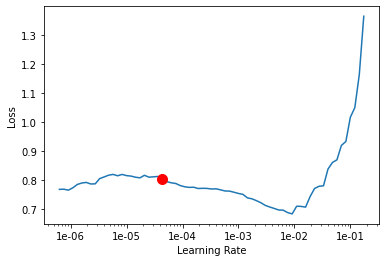

In [54]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.794156,0.611330,0.803560,0.777370,0.809673,0.790015,0.803560,0.782640,0.805746,03:11
1,0.552632,0.455603,0.791481,0.769574,0.811897,0.795827,0.791481,0.776362,0.796287,03:11
2,0.431283,0.385419,0.810553,0.792099,0.806329,0.765605,0.810553,0.775841,0.806067,03:12
3,0.308550,0.364826,0.830261,0.806962,0.831634,0.811382,0.830261,0.809074,0.830867,03:12
4,0.224963,0.379458,0.836618,0.825922,0.834008,0.793409,0.836618,0.805873,0.832345,03:12


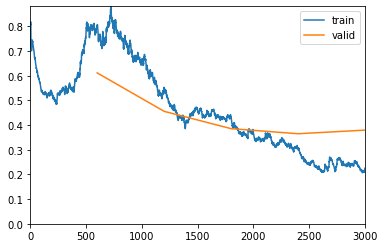

Better model found at epoch 0 with accuracy value: 0.8035600781440735.
Better model found at epoch 2 with accuracy value: 0.8105530738830566.
Better model found at epoch 3 with accuracy value: 0.8302606344223022.
Better model found at epoch 4 with accuracy value: 0.8366179466247559.


In [55]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-2), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.291173,0.399506,0.823268,0.798999,0.831457,0.816540,0.823268,0.805862,0.825781,03:19
1,0.216698,0.430584,0.830896,0.814860,0.827819,0.792604,0.830896,0.801765,0.827805,03:20


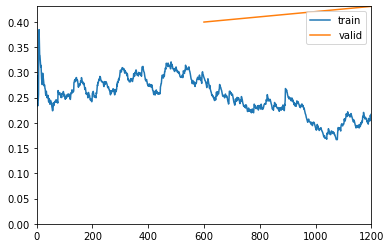

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.364537,0.423454,0.813096,0.791047,0.810001,0.777371,0.813096,0.783333,0.810850,04:08
1,0.335770,0.359622,0.827082,0.810791,0.823800,0.787295,0.827082,0.796828,0.823693,04:05
2,0.118365,0.405743,0.834075,0.811404,0.835040,0.814716,0.834075,0.813006,0.834514,04:06


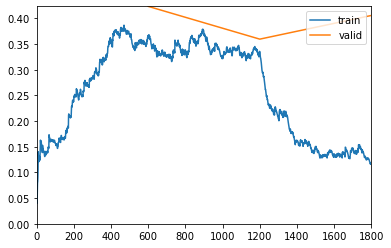

In [57]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


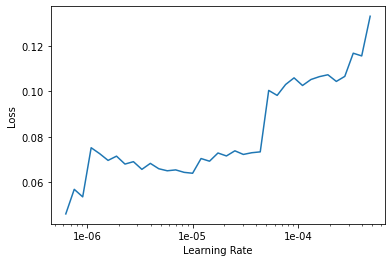

In [58]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.094701,0.409154,0.844247,0.825987,0.842584,0.816862,0.844247,0.821082,0.843142,04:44
1,0.080719,0.425109,0.828353,0.804232,0.833581,0.817366,0.828353,0.809824,0.830165,04:45


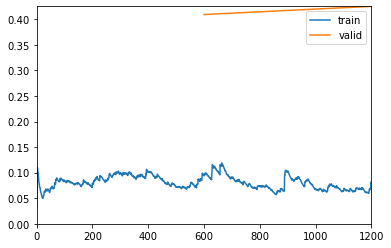

In [59]:
learn.fit_one_cycle(2, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.081573,0.440706,0.842339,0.828482,0.839748,0.806063,0.842340,0.815390,0.839559,04:45
1,0.061722,0.442192,0.839161,0.821907,0.836787,0.807151,0.839161,0.813650,0.837276,04:46
2,0.047800,0.475866,0.839161,0.821907,0.836787,0.807151,0.839161,0.813650,0.837276,04:44
3,0.032486,0.484462,0.837889,0.819215,0.835852,0.808178,0.837889,0.813187,0.836464,04:45


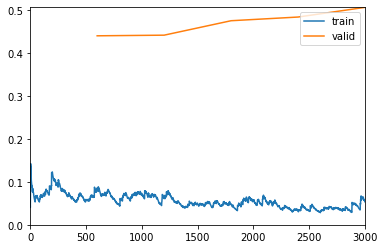

Better model found at epoch 0 with accuracy value: 0.8423394560813904.
Epoch 1: reducing lr to 9.504846320134737e-06
Epoch 2: reducing lr to 6.112620219362892e-06
Epoch 3: reducing lr to 1.8825834605023696e-06
Epoch 4: early stopping


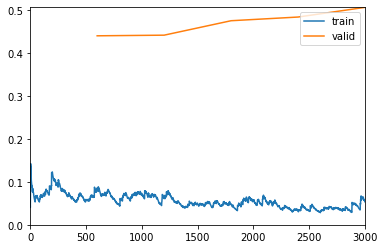

In [60]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [61]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

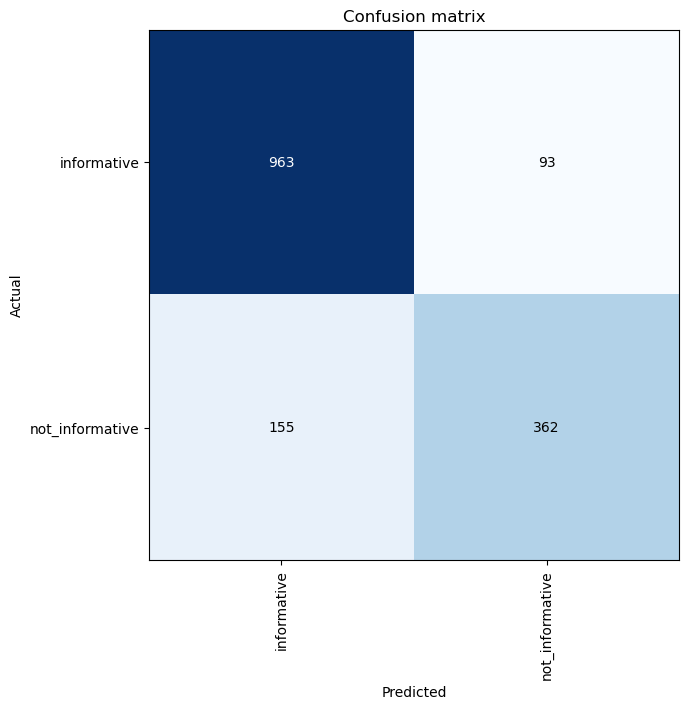

In [62]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [63]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.44070643,
 tensor(0.8423),
 tensor(0.8285),
 tensor(0.8397),
 tensor(0.8061),
 tensor(0.8423),
 tensor(0.8154),
 tensor(0.8396)]

In [64]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.86      0.91      0.89      1056
not_informative       0.80      0.70      0.74       517

       accuracy                           0.84      1573
      macro avg       0.83      0.81      0.82      1573
   weighted avg       0.84      0.84      0.84      1573



In [65]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.43616095,
 tensor(0.8553),
 tensor(0.8396),
 tensor(0.8536),
 tensor(0.8279),
 tensor(0.8553),
 tensor(0.8332),
 tensor(0.8540)]

In [66]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.88      0.91      0.89      1030
not_informative       0.80      0.75      0.77       504

       accuracy                           0.86      1534
      macro avg       0.84      0.83      0.83      1534
   weighted avg       0.85      0.86      0.85      1534

